# Introduction

This work reproduces the original paper from Duvenaud, *et. al.* on the development of convolutional neural networks applied on molecular graphs that generate molecular fingerprints (i.e., embeddings) for downstream property prediction. Citation to the original paper [1]:

Duvenaud, D. K., Maclaurin, D., Iparraguirre, J., Bombarell, R., Hirzel, T., Aspuru-Guzik, A., and Adams, R. P. (2015) Convolutional networks on graphs for learning molecular fingerprints. *Advances in Neural Information Processing Systems*, 2224-2232.

The Github repository to this replication work can be found at [https://github.com/wangcp93/dlh-fps](https://github.com/wangcp93/dlh-fps)

## General Problem

This paper aims at learning molecular features using molecule graphs of arbitrary size and shape as inputs. This is an important problem in drug discovery because molecular feature extraction is the foundation for downstream tasks, such as molecular property prediction. The main challenge of this problem is to realize end-to-end learning, i.e., using molecule graphs as the direct inputs rather than converting them to fixed-size inputs via predefined rules.

Before this paper, the state of the art was to use extended-connectivity circular fingerprints (ECFP) of molecules [2], which are fixed-dimensional multi-hot vectors relying on hand-crafted features. These vectors are often very high-dimensional but sparse. Also, they are fixed regardless of downstream tasks, so the predictive power is limited in many tasks.

## Approach to the Problem

This paper generalizes the circular fingerprints to “neural fingerprints”, which are optimizable based on downstream tasks and data. To facilitate the training, this method replaces several non-differentiable operations to a differentiable neural network. By doing so, the model can be trained in an end-to-end manner directly from molecule graphs. Specifically, in each layer:

* A smooth activation function replaces the hashing operation to combine information from the neighborhood of each atom.
* A softmax function replaces the indexing (argmax) operation to sparsify each atom’s feature vector.
* A real-valued fingerprint vector replaces the binary vector to better preserve similarity information between substructures.

This paper demonstrated that, compared with circular fingerprints, the neural fingerprints are more interpretable, and the predictive errors on 3 downstream tasks (solubility, drug efficacy, photovoltaic efficiency) can be much lower.
Such approach applies the same operation locally everywhere and combines information in a global pooling step, which resembles a convolutional network. In fact, though not explicitly, this paper was the first that proposed the idea of graph convolutional network (GCN).

# Scope of Reproducibility:

## Hypothesis Testing

The folliwing hypotheses from the paper will be tested in this work:

1. Hypothesis 1: Data-driven neural fingerprints achieve greater predictive performances than fixed circular fingerprints.

2. Hypothesis 2: Circular fingerprints are a special case of neural fingerprints by having large random weights.

To test the first hypothesis, this work will replicate the studies on 3 downstream tasks provided in the paper (solubility, drug efficacy, and photovoltaic efficacy) to evaluate the model performance.

To test the second hypothesis, this work will replicate the training of the model using large and small random weights, respectively, to show that the former achieves similar performance as circular fingerprints, while the latter gives better results.


## Ablation Study

Key differences between the neural fingerprints and circular fingerprints are the use of (a) a neural network instead of a hashing operation, and (b) a softmax function to give a real-valued vector instead of an indexing operation to give a binary vector. While (a) is the main contribution, its ablation is challenging due to the non-differentiable nature of the hashing operation. Here, I propose ablation study on (b). Specifically:

* After the neural network layer, use a global max pooling followed by normalization to mimic the indexing operation (instead of softmax) that generates binary vectors as fingerprints.

This is to assess whether real-valued fingerprint vectors are advantageous compared with binary vectors. If it makes minimal difference in predictive performance, it supports the main conclusion that data-driven features are superior to fixed features, even if some components are suboptimal.

# Methodology

The necessary packages are imported below, and the seed is set.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import random
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Import helper codes from the authors
import sys
sys.path.append("neuralfingerprint")

# Converts smiles to mol graphs and extract atom and bond features
from mol_graph import graph_from_smiles_tuple

# Import the atom and bond feature length for building the model
from features import num_features

In [2]:
# set seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

## Data

This paper uses 3 datasets for training and performance evaluation:

* Solubility: The aqueous solubility of ~1100 organic molecules, measured in mols per litre in log scale [3].
* Drug efficacy: The half-maximal effective concentration (EC<sub>50</sub>) in vitro in log scale of ~10,000 molecules against a sulfide-resistant strain of *P. falciparum*, the parasite that causes malaria [4].
* Organic photovoltaic efficiency: The DFT-simulated photovoltaic efficiency of ~30,000 organic molecules from the Harvard Clean Energy Project [5].

All the data have been provided by the authors as csv files. Because of the small sizes, they are directly accessed from local folders. The smiles strings are used as the direct inputs to the model without preprocessing at this stage.

### Molecular Features

All the molecules are represented by a SMILES string. The paper processes the molecules using rdkit and self-defined methods in `mol_graph.py` to generate molecular graphs and extract features. The features include atom features and bond features defined in `features.py`. Specifically:

* Initial atom features concatenate a one-hot encoding of the atom’s element, its degree, the number of attached hydrogen atoms, the implicit valence, and an aromaticity indicator.
* The bond features are a concatenation of whether the bond type was single, double, triple, or aromatic, whether the bond was conjugated, and whether the bond was part of a ring.

The feature vector lengths are shown below.

In [3]:
atom_feature_size, bond_feature_size = num_features()
print("atom feature vector length:", atom_feature_size)
print("bond feature vector length:", bond_feature_size)

atom feature vector length: 62
bond feature vector length: 6


### Load datasets

Below the 3 datasets are loaded separately. Some helper functions are defined below.

In [4]:
# Data direction
data_dir = 'data'

# Define validation and test ratio
val_ratio = 0.1
test_ratio = 0.1

# Load data as a Pandas data frame
def load_data(data_dir, data_file, target_name):
    df = pd.read_csv(f"{data_dir}/{data_file}")[["smiles", target_name]]
    df.rename(columns={target_name: "label"}, inplace = True)
    return df

# calculate statistics and plot histogram for the label distribution
def print_label_statistics(data_df, target_name):
    label = data_df["label"]
    
    # Generate statistics
    print("Count:", len(label))
    print("Mean:", f"{label.mean():.2f}")
    print("Stdev:", f"{label.std():.2f}")
    print("Median:", f"{label.median():.2f}")
    print("Max:", f"{label.max():.2f}")
    print("Min:", f"{label.min():.2f}")
    
    # Generate histogram
    plt.figure(figsize = (4, 3))
    label.plot.hist(bins = 10)
    plt.title(f'Histogram of {target_name}')
    plt.xlabel(target_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


### 1. Solubility Dataset

The Solubility dataset is imported below:

In [5]:
sol_df = load_data(data_dir, data_file = 'delaney.csv',
                   target_name = 'measured log solubility in mols per litre')
sol_df.head()

,smiles,label
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


The dataset is split into training, validation and test sets. The test set is saved for the final evaluation, while the training and validation sets are used during training. In each epoch, the data set is shuffled, and the validation set is regenerated randomly. Below the test set is split and saved:

In [6]:
# Splitting into train+val and test sets. Save the test set for final evaluation
sol_train_val_df, sol_test_df = train_test_split(sol_df, test_size = test_ratio, random_state = seed)

print("Dataset size:", sol_df.shape[0])
print("Test set size:", sol_test_df.shape[0] )

Dataset size: 1128
Test set size: 113


Statistics of the log solubility of molecules are shown below.

Count: 1128
Mean: -3.05
Stdev: 2.10
Median: -2.86
Max: 1.58
Min: -11.60


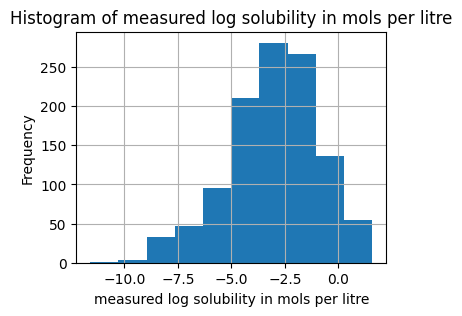

In [7]:
print_label_statistics(sol_df, 'measured log solubility in mols per litre')

### 2. Drug Efficacy Dataset

The Drug Efficacy dataset is imported below, followed by train/test split and statistics review.

In [8]:
eff_df = load_data(data_dir, data_file = 'malaria.csv', target_name = 'activity')
eff_df.head()

,smiles,label
0,Cc1nc2cc(ccc2[nH]1)c3ccc4[nH]c(C)nc4c3,0.738598
1,CN(C1CCN(C)C1)c2cc(C)nc(Nc3ccc(Cl)cc3)n2,-1.090085
2,CN(C)CCCOc1cc(NC(=O)Nc2ccc(c3ccncc3)c4ccccc24)...,-0.358682
3,COc1ccc(cc1CSc2nc3ccccc3[nH]2)C4NCCc5c4[nH]c6c...,0.561329
4,CCN1C(=Nc2sc3CN(C)CCc3c2C1=O)SCc4ccc(F)cc4,-1.371137


In [9]:
# Splitting into train+val and test sets. Save the test set for final evaluation
eff_train_val_df, eff_test_df = train_test_split(eff_df, test_size = test_ratio, random_state = seed)

print("Dataset size:", eff_df.shape[0])
print("Test set size:", eff_test_df.shape[0] )

Dataset size: 9999
Test set size: 1000


Count: 9999
Mean: -0.34
Stdev: 1.22
Median: -0.22
Max: 2.71
Min: -6.92


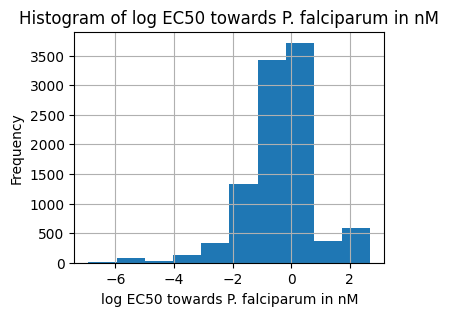

In [10]:
print_label_statistics(eff_df, 'log EC50 towards P. falciparum in nM')

### 3. Photovoltaic Efficiency Dataset

The Organic Photovoltaic Efficiency dataset is imported below, followed by train/test split and statistics review.

In [11]:
pce_df = load_data(data_dir, data_file = 'cep.csv', target_name = 'PCE')
pce_df.head()

,smiles,label
0,c1cc2c3cocc3c3c4[SiH2]C(=Cc4ncc3c2[se]1)c1scc2...,3.596639
1,C1C=Cc2ncc3c4[se]c(cc4c4=C[SiH2]C=c4c3c12)-c1c...,5.993001
2,[nH]1c(cc2c3nsnc3c3c4ccccc4oc3c12)-c1ccco1,2.855376
3,[nH]1c2cc(-c3nccc4nsnc34)c3nsnc3c2c2ncc3cccnc3c12,7.611321
4,[nH]1c2ccc3c[nH]cc3c2c2ccc3cc(ncc3c12)-c1scc2s...,1.471250


In [12]:
# Splitting into train+val and test sets. Save the test set for final evaluation
pce_train_val_df, pce_test_df = train_test_split(pce_df, test_size = test_ratio, random_state = seed)

print("Dataset size:", pce_df.shape[0])
print("Test set size:", pce_test_df.shape[0] )

Dataset size: 29978
Test set size: 2998


Count: 29978
Mean: 3.90
Stdev: 2.54
Median: 3.41
Max: 11.09
Min: -6.95


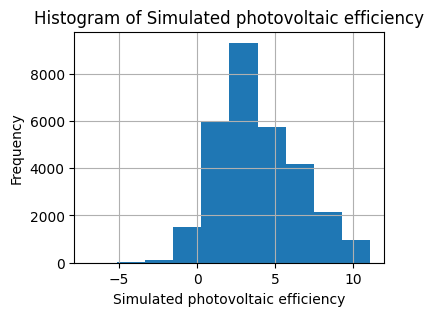

In [13]:
print_label_statistics(pce_df, 'Simulated photovoltaic efficiency')

##   Model

The neural graph fingerprints algorithm is outlined below:

**Input**: molecule, radius $R$, atom feature weights $W_1^a$, ..., $W_R^a$, neighbor feature weights $W_1^n$, ..., $W_R^n$, fingerprint weights $W_1^f$, ..., $W_{R}^f$

**Initialize**: fingerprint vector $\textbf{f}=\textbf{0}$

**for** each atom $a$ in molecule

&emsp; $\textbf{r}_a = g(a)$ &emsp; *# lookup atom features*

**for** $L = 1$ to $R$ &emsp; *# for each layer*

&emsp; **for** each atom $a$ in molecule

&emsp;&emsp; $\textbf{r}_1 ... \textbf{r}_N = \text{neighbors}(a)$

&emsp;&emsp; $\textbf{v} = W_L^a\textbf{r}_a + W_L^n\sum_{i=1}^N{\textbf{r}_i}$

&emsp;&emsp; $\textbf{r}_a = \text{ReLU}(\textbf{v})$ &emsp; *# update atom features*

&emsp;&emsp; $\textbf{i} = \text{Softmax} (W_L^f\textbf{r}_a)$

&emsp;&emsp; $\textbf{f} = \textbf{f} + \textbf{i}$ &emsp; *# add to fingerprint*

**Return**: real-valued vector $\textbf{f}$

In this algorithm:

* The radius $R$ is essentially the number of layers in the neural network, where each layer extends neighbor coverage by one atom. This is why it is called the radius. In this work, I used $R = 4$.

* The hidden layer dimension is set to be the same as the atom feature dimension, which in this case is 62. Thus, each atom feature weight matrix $W_L^a$ has size (62, 62). Since the bond feature vector length is 6, each neighbor feature weight matrix $W_L^n$ has size (68, 62).

* The fingerprint length in the paper is set to 50. Thus, each fingerprint weight matrix $W_L^f$ has size (62, 50).

* Finally, an output linear layer will map the fingerprint to a numerical value as the output for property prediction.

It is noteworthy that, despite the pseudocode of the algorithm uses distinct for loops over atoms in a molecule, all atoms in the molecule are calculated simultaneously. In fact, all molecules within the same batch are handled simultaneously by the code.

Lastly, there is no pretraining or simulation involved in the model. Each dataset is trained separately end-to-end.

### Model Class

Because the original paper used outdated codes to build the model and perform the training, I rewrite the model codes using PyTorch. The model class built on torch.nn class module is defined below. 

In [14]:
class NeuralFingerprint(nn.Module):
    def __init__(self, atom_feature_size, bond_feature_size, fp_length, fp_depth, degrees = (0,1,2,3,4,5)):
        super(NeuralFingerprint, self).__init__()
        
        self.layers = fp_depth  # fingerprint depth is the number of layers for neural network
        self.degrees = degrees  # degrees define how many non-H atom connect to a given atom
        
        # Linear layer that maps features of the atom to the next layer. Each layer has separate parameters
        self.W_atoms = nn.ModuleList([nn.Linear(atom_feature_size, atom_feature_size) 
                                      for _ in range(self.layers)])
        
        # Linear layer that maps features of neighbors to the next layer. Each layer has separate parameters
        self.W_neighbors = nn.ModuleList([nn.Linear(atom_feature_size + bond_feature_size, 
                                                    atom_feature_size, bias = False) 
                                          for _ in range(self.layers)])
        
        # Linear layer that maps atom features to fingerprints. Each layer has separater parameters
        self.W_fps = nn.ModuleList([nn.Linear(atom_feature_size, fp_length) 
                                    for _ in range(self.layers)])
        
        # final prediction layers
        self.W_pred = nn.Linear(fp_length, 1)
        
    
    # Generates array representations for smiles, including atom features and bond features
    # Handles a batch of smiles simultaneously
    # The atom list and neighbors list records which atoms/bonds belong to which molecule
    def array_rep_from_smiles(self, smiles_batch):
        
        molgraph = graph_from_smiles_tuple(smiles_batch)
        arrayrep = {
            'atom_features' : molgraph.feature_array('atom'),
            'bond_features' : molgraph.feature_array('bond'),
            'atom_list'     : molgraph.neighbor_list('molecule', 'atom') # List of lists
        }

        for degree in self.degrees:
            arrayrep[('atom_neighbors', degree)] = \
                torch.tensor(molgraph.neighbor_list(('atom', degree), 'atom'), dtype = torch.int)
            arrayrep[('bond_neighbors', degree)] = \
                torch.tensor(molgraph.neighbor_list(('atom', degree), 'bond'), dtype = torch.int)
        return arrayrep

    
    # Helper function that finds the neighbors of each atom and multiplies them with the neighbor parameters
    def matmult_neighbors(self, array_rep, atom_features, bond_features, layer):
        # Sort neighbors by degrees
        activations_by_degree = []
        for degree in self.degrees:
            atom_neighbors_list = array_rep[('atom_neighbors', degree)]
            bond_neighbors_list = array_rep[('bond_neighbors', degree)]

            if len(atom_neighbors_list) > 0:
                neighbor_features = [atom_features[atom_neighbors_list],
                                     bond_features[bond_neighbors_list]]

                # dim of stacked_neighbors is (num_atoms, num_neighbors, neighbor_feature_dim)
                stacked_neighbors = torch.cat(neighbor_features, dim=2)

                # dim of summed_neighbors is (num_atoms, neighbor_feature_dim)
                summed_neighbors = torch.sum(stacked_neighbors, dim=1)

                # Apply the linear layer. Output dim is (num_atoms, atom_feature_dim)
                activations = self.W_neighbors[layer](summed_neighbors)
                activations_by_degree.append(activations)

        # Concatenate neighbor features from all degrees. Output dim is (total_num_atoms, atom_feature_dim)
        return torch.cat(activations_by_degree, dim=0)
    
    
    # Updates the atom features based on neighbor information in each layer
    def update_layer(self, array_rep, atom_features, bond_features, layer):
        
        # Apply the linear layer to the atom itself. Output dim is (num_atoms, atom_feature_dim)
        self_activations = self.W_atoms[layer](atom_features)
        
        # Apply the linear layer to the neighbors. Output dim is (num_atoms, atom_feature_dim)
        neighbour_activations = self.matmult_neighbors(array_rep, atom_features, bond_features, layer)

        # Sum them up and apply ReLU activation. Output dim is (num_atoms, atom_feature_dim)
        total_activations = neighbour_activations + self_activations
        return torch.relu(total_activations)
    
    
    # Converts atom features to fingerprints in a single layer
    def feature_to_fp(self, array_rep, atom_features, layer):
        
        # Apply the linear layer followed by softmax activation. Output dim is (num_atoms, fp_dim)
        atom_outputs = torch.softmax(self.W_fps[layer](atom_features), dim=1)

        # Reorganize atoms for each molecule in the batch, and sum up fingerprints for each molecule
        mol_outputs = [torch.sum(atom_outputs[idx_list], dim=0) for idx_list in array_rep['atom_list']]
        
        # Concatenate fingerprints of each molecule. Output dim is (batch_size, fp_dim)
        layer_output = torch.cat([torch.unsqueeze(x, dim=0) for x in mol_outputs], dim=0)     
        return layer_output
    
    
    # Overall fingerprint generation function over all layers
    def fp_generation(self, array_rep, atom_features, bond_features):
        all_layer_fps = []

        for layer in range(self.layers):
            # For each layer, update atom features, then generate fingerprint
            atom_features = self.update_layer(array_rep, atom_features, bond_features, layer)
            all_layer_fps.append(self.feature_to_fp(array_rep, atom_features, layer))
        
        # Sum up fingerprint of each molecule from all layers. Output dim is (batch_size, fp_dim)
        stacked_fps = torch.stack(all_layer_fps)
        return torch.sum(stacked_fps, dim=0)
        
    
    # A one-layer neural network to generate output prediction. Output dim is (batch_size, 1)
    def output_pred(self, batch_fps):
        return self.W_pred(batch_fps)

    
    # Forward function
    def forward(self, smiles_batch):
        
        # Generate array representation of the batch of smiles, and extract initial atom and bond features
        array_rep = self.array_rep_from_smiles(tuple(smiles_batch))
        atom_features = array_rep['atom_features'].type(torch.float)
        bond_features = array_rep['bond_features'].type(torch.float)
        
        # Calculate molecular fingerprints and then the final output
        fingerprints = self.fp_generation(array_rep, atom_features, bond_features)
        batch_predicted = self.output_pred(fingerprints)
        
        return batch_predicted

    
model = NeuralFingerprint(atom_feature_size = 62, bond_feature_size = 6, fp_length = 50, fp_depth = 4)

### Model Training

The model is trained using Atam algorithm:

* Because all 3 tasks are regressions, mean squared error loss is used as the loss function
* As a regularization, L2 loss is added. Specifically, the weight_decay argument is used to implement the L2 loss. The regularization strength is the same as the original paper, i.e., exp(-4).
* Batch size is set to 100, and the training takes 100 epochs, both of which are the same as the original paper.
* Training and validation error is quantified by root mean square error, which is used in the original paper.

The training can be finished in several minutes using a laptop, without the need of a GPU. As a demonstration, below only shows the training for Solubility dataset.

In [15]:
batch_size = 100
num_epoch = 100
L2_reg = np.exp(-4)
step_size = np.exp(-6)

# MSE loss as the loss function
criterion = nn.MSELoss()

# Adam optimizer with L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr = step_size, weight_decay = L2_reg)

# Records training losses, training and validation errors per epoch
train_losses = []
train_rmses = []
val_rmses = []


for epoch in range(num_epoch):
    """ model training """
    
    # Split to training and validation sets randomly
    train_df, val_df = train_test_split(sol_train_val_df, test_size = val_ratio, random_state = seed + epoch)
    
    model.train()
    
    train_loss = 0
    pred_list, label_list = [], []
    
    # Loop over batches
    for i in range(0, train_df.shape[0], batch_size):
        batch_df = train_df.iloc[i: i+batch_size]
        smiles_batch = batch_df["smiles"].tolist()
        label = torch.FloatTensor(batch_df["label"].tolist())
        
        # feed smiles into the model
        pred = model.forward(smiles_batch).squeeze(1)
        
        # Calculate loss
        loss = criterion(pred, label)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss.item()
        
        pred_list.append(pred)
        label_list.append(label)
    
    # Record training error as RMSE
    train_error = root_mean_squared_error(torch.cat(label_list).detach(), torch.cat(pred_list).detach())
    train_rmses.append(train_error)
    
    # Record training loss
    train_losses.append(train_loss)
    
    """ model evaluation """
    model.eval()
    pred_list, label_list = [], []
    
    with torch.no_grad():
        # Loop over batches
        for i in range(0, val_df.shape[0], batch_size):
            batch_df = val_df.iloc[i: i+batch_size]
            smiles_batch = batch_df["smiles"].tolist()
            label = torch.FloatTensor(batch_df["label"].tolist())
            
            # feed features into the model
            pred = model.forward(smiles_batch).squeeze(1)
            pred_list.append(pred)
            label_list.append(label)
        
        # Record validation error as RMSE
        val_error = root_mean_squared_error(torch.cat(label_list), torch.cat(pred_list))
        val_rmses.append(val_error)
    
    # Print loss and errors every 5 epochs
    if (epoch+1) % 5 == 0:
        print (f"--- epoch: {epoch+1} ---, train loss: {train_loss:.2f}, train RMSE: {train_error:.2f}, val RMSE: {val_error:.2f}")

--- epoch: 5 ---, train loss: 22.01, train RMSE: 1.50, val RMSE: 1.49
--- epoch: 10 ---, train loss: 11.96, train RMSE: 1.07, val RMSE: 1.15
--- epoch: 15 ---, train loss: 9.63, train RMSE: 0.96, val RMSE: 1.12
--- epoch: 20 ---, train loss: 9.52, train RMSE: 0.95, val RMSE: 0.82
--- epoch: 25 ---, train loss: 8.55, train RMSE: 0.95, val RMSE: 0.99
--- epoch: 30 ---, train loss: 6.94, train RMSE: 0.85, val RMSE: 0.89
--- epoch: 35 ---, train loss: 8.03, train RMSE: 0.89, val RMSE: 0.81
--- epoch: 40 ---, train loss: 7.70, train RMSE: 0.88, val RMSE: 0.88
--- epoch: 45 ---, train loss: 6.98, train RMSE: 0.84, val RMSE: 0.78
--- epoch: 50 ---, train loss: 9.74, train RMSE: 0.96, val RMSE: 0.78
--- epoch: 55 ---, train loss: 6.23, train RMSE: 0.79, val RMSE: 0.84
--- epoch: 60 ---, train loss: 8.96, train RMSE: 0.96, val RMSE: 0.86
--- epoch: 65 ---, train loss: 6.02, train RMSE: 0.78, val RMSE: 1.01
--- epoch: 70 ---, train loss: 5.82, train RMSE: 0.78, val RMSE: 0.69
--- epoch: 75 ---, 

# Results

## Training Results

To plot training results, we define two plotting functions for training loss and training/validation errors:

In [16]:
# Plot training loss over iterations
def plot_train_loss(train_losses):
    epochs = list(range(1, len(train_losses) + 1))
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, train_losses, marker='', linestyle='-')
    plt.title('Training loss over the number of training epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training loss')
    plt.grid(True)
    plt.show()

# Plot training and validation error over iterations
def plot_train_val_error(train_err, val_err):
    epochs = list(range(1, len(train_losses) + 1))
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, train_err, marker='', linestyle='-', label = "Train RMSE")
    plt.plot(epochs, val_err, marker='', linestyle='-', label = "Val RMSE")
    plt.title('RMSE over the number of training epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.legend()
    plt.show()

The training loss is plotted below. The loss decrease plateaus after about 40 epochs.

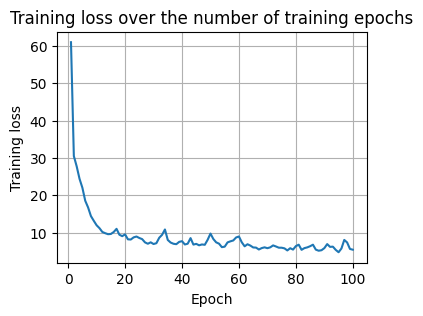

In [17]:
plot_train_loss(train_losses)

The training and validation errors as RMSE are plotted below. The errors also plateau after about 40 epochs, indicating that the training may be stopped earlier. In addition, the training and validation errors stay close, indicating minimal overfitting.

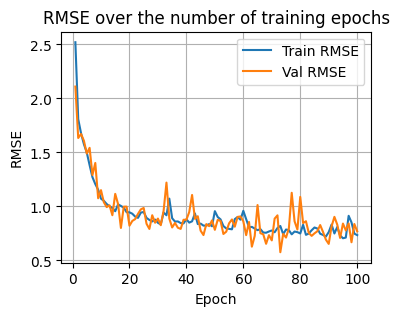

In [18]:
plot_train_val_error(train_rmses, val_rmses)

## Performance on Test Set

The trained model is applied on the test set to get the final model performance as root mean square error (RMSE) between true labels and predicted outcomes, which is the same as the original paper. According to the paper, the RMSE on the Solubility dataset reaches 0.52, which is better than the current version of the reproducibility.

In [19]:
model.eval()
    
with torch.no_grad():
    smiles_test = sol_test_df["smiles"].tolist()
    label_test = torch.FloatTensor(sol_test_df["label"].tolist())

    # feed features into the model
    pred_test = model.forward(smiles_test).squeeze(1)

    # Calculate test error as RMSE
    test_error = root_mean_squared_error(label_test, pred_test)

print(f"RMSE on the test set: {test_error:.2f}")

RMSE on the test set: 0.79


# Plans

So far, the model is successfully rewritten using PyTorch, and the training and evaluation can be smoothly run. However, the preliminary reproduction result has not reached the performance that the paper reported. It is hypothesized that, when the training environment changes from mostly self-implemented codes by the authors to PyTorch, some hyperparameters may no longer be optimal, such as learning rate, L2 penalty strength, hidden layer size, and etc.

Moreover, another important factor could be the initial weight scale. As the authors mention in the paper, large initial parameters perform similarly to the circular fingerprints method (previous method) while small initial parameters are the key to improve performance.

Therefore, the plans to finish the replication study will include:

1. Fine-tune hyperparameters, especially the initial weight scale, to reach a better performance, aiming at reproducing the results reported in the original paper.

2. Finish the model training and evaluation on the other two datasets and make comparisons to the reported results.

3. Continue to finish the testing of Hypothesis 2 and Ablation studies based on the built model architecture.



In [20]:
# metrics to evaluate my model

# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

## Model comparison

In [21]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [22]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

'\nif you want to use an image outside this notebook for explanaition,\nyou can read and plot it here like the Scope of Reproducibility\n'

# References

1. Duvenaud D. K., Maclaurin D., Iparraguirre J., Bombarell R., Hirzel T., Aspuru-Guzik A. and Adams R. P. (2015) Convolutional networks on graphs for learning molecular fingerprints. *Advances in Neural Information Processing Systems*, 2224-2232.

2. Rogers D. and Hahn M. (2010) Extended-connectivity fingerprints. *Journal of Chemical Information and Modeling*, 50(5): 742-754.

3. Delaney J. S. (2004) ESOL:Estimating aqueous solubility directly from molecular structure. *Journal of Chemical Information and Computer Sciences*, 44(3): 1000–1005.

4. Gamo F.-J., Sanz L. M., Vidal J., de Cozar C., Alvarez E., Lavandera J.-L., Vanderwall D. E., Green D. V. S., Kumar V., Hasan S., Brown J. R., Peishoff C. E., Cardon L. R. and Garcia-Bustos J. F. (2010) Thousands of chemical starting points for antimalarial lead identification. *Nature*, 465(7296): 305–310.

5. Hachmann J., Olivares-Amaya R., Atahan-Evrenk S., Amador-Bedolla C., Sánchez-Carrera R. S., Gold-Parker A., Vogt L., Brockway A. M. and Aspuru-Guzik A. (2011) *The Journal of Physical Chemistry Letters*, 2(17): 2241–2251.

# Feel free to add new sections